In [1]:
!lsb_release -a #Linux info
!cat /proc/cpuinfo # CPU info
!df -h #disc info
!cat /proc/meminfo #RAM info
#!sudo apt install speedtest-cli #library for speedtesting
#!speedtest-cli # network speed test
!nvidia-smi #GPU info

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.4 LTS
Release:	20.04
Codename:	focal
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) Silver 4215R CPU @ 3.20GHz
stepping	: 7
microcode	: 0x500320a
cpu MHz		: 3200.308
cache size	: 11264 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 8
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush acpi mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl cpuid pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch cpuid_fault invpcid_single pti intel_ppin ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid rdseed adx smap xsaveopt md_clear flush_l1d
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_s

In [2]:
#!sudo apt install unrar
#!unrar e /notebooks/drawings.rar /notebooks/DATA/drawings
#!unrar e /notebooks/engraving.rar /notebooks/DATA/engravings
#!unrar e /notebooks/painting.rar /notebooks/DATA/painting
#!unrar e /notebooks/iconography.rar /notebooks/DATA/iconography
#!unrar e /notebooks/sculpture.rar /notebooks/DATA/sculpture

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unrar is already the newest version (1:5.6.6-2build1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.

UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /notebooks/drawings.rar

No files to extract

UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /notebooks/engraving.rar

No files to extract

UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /notebooks/painting.rar

No files to extract

UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal

Unexpected end of archive

Extracting from /notebooks/iconography.rar

Unexpected end of archive
No files to extract


In [3]:
from PIL import Image
import os,time
import cv2

#img_dir='/notebooks/DATA'
def verify_folder(folder_dir):
    
    def verify_image(img_file):
         #test image
         try:
            v_image = Image.open(img_file)
            v_image.verify()
            return True;
            #is valid
            #print("valid file: "+img_file)
         except OSError:
            return False;

    for root, dirs, files in os.walk(folder_dir):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                currentFile=os.path.join(root, file)
                #print(currentFile)
                #test image
                if verify_image(currentFile):
                    im = cv2.imread(currentFile)
                    if im.shape[0] < 64 or im.shape[1] < 64:
                        print('undersized file')
                        os.remove(currentFile)
                else:
                    os.remove(currentFile)
                    print("corrupt file")
                    
            else:
                os.remove(os.path.join(root, file))
                print("unsupported file extension")
    print('DONE')
                    
verify_folder('/notebooks/DATA')


unsupported file extension
unsupported file extension


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


undersized file


libpng warning: iCCP: known incorrect sRGB profile


undersized file
undersized file
undersized file
undersized file
undersized file
unsupported file extension
DONE


In [1]:
# import the required packages

import torch
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.utils as vutils
from matplotlib.pyplot import figure

# DataLoader 
import os
from os import listdir
from os.path import isfile, join
from PIL import Image
import cv2

In [6]:
# HyperParameters
batch_size = 1024
learning_rate = 0.01
betas=(0.5, 0.999) #beta1, beta2 for Adam Optimizer
momentum = 0.9 # for SGD optimizer

In [3]:
class ArtDataset(Dataset):
    """Art dataset"""

    def __init__(self, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = []
        self.dirName_1 = '/notebooks/DATA'
        self.files_list = []
        self.transform = transform
        self.load_images()
        

    def load_images(self):
        
        for root, dirs, files in os.walk(self.dirName_1):
            for file in files:
                #print(root, file)
                self.files_list.append(os.path.join(root, file))
                    
        self.labels = np.full(shape=len(self.files_list), fill_value=0, dtype=int)
            

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
    
        image = Image.open(self.files_list[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
            

        return (image, label)

In [4]:
# can be omitted if mean and std is already calculated
# for calcualting mean and std od dataset
def get_mean_and_std(dataset):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(dataset):
        #print(data.shape)
        # Mean over height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[1,2])
        channels_squared_sum += torch.mean(data**2, dim=[1,2])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean: [0.5927285552024841, 0.538730263710022, 0.4859641492366791], std: [0.30223119258880615, 0.2943011224269867, 0.2963792085647583]


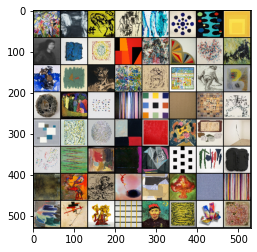

In [19]:
# Calculate mean and std
train_transform_WN = transforms.Compose([transforms.ToTensor(),
                                         transforms.Resize((64, 64))])
Calc_dataset = ArtDataset(transform=train_transform_WN)

#mean, std = get_mean_and_std(Calc_dataset)

train_Calc_dataset = torch.utils.data.DataLoader(dataset=Calc_dataset, batch_size=64, shuffle=True, num_workers=2)
loaded_images=next(iter(train_Calc_dataset))[0]
loaded_images_array = np.transpose(vutils.make_grid(loaded_images, padding=2, normalize=True).cpu().detach().numpy(),(1,2,0))
plt.imshow(loaded_images_array)

del Calc_dataset
print(f'mean: {mean.tolist()}, std: {std.tolist()}')

In [20]:
train_transform = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Resize((64, 64)),
                                      transforms.Normalize(mean.tolist(), std.tolist())])

train_dataset = ArtDataset(transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f'length of dataset: {len(train_dataset)}')

length of dataset: 16408


In [21]:
# Generator Model Class Definition
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Block 1:input is Z, going into a convolution
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, biastrain_Calc_dataset=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: input is (64 * 8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: input is (64 * 4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: input is (64 * 2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 5: input is (64) x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: output is (3) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

# Discriminator Model Class Definition
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Block 1: input is (3) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: input is (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: input is (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: input is (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 5: input is (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
            # Output: 1
        )

    def forward(self, input):
        output = self.main(input)
        output  = output.reshape(output.shape[0])
        return output

    # custom weights initialization called on gen and disc model
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [21]:
# Generator Model Class Definition
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Block 1:input is Z, going into a convolution
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: input is (64 * 8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: input is (64 * 4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: input is (64 * 2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 5: input is (64) x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: output is (3) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

# Discriminator Model Class Definition
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Block 1: input is (3) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: input is (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: input is (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: input is (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 5: input is (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
            # Output: 1
        )

    def forward(self, input):
        output = self.main(input)
        output  = output.reshape(output.shape[0])
        return output

    # custom weights initialization called on gen and disc model
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [9]:
# set the device we will be using
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True #let cudnn choose most efficient way of calculating convulsions

generator = Generator().to(device)
generator.apply(weights_init)
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
adversarial_loss = nn.BCELoss()

def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    return gen_loss

def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss


G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=betas)
D_optimizer = optim.SGD(discriminator.parameters(), lr = learning_rate, momentum=momentum)

# I decided to use external plotting service Weights and biases. It provides easy live preview of model state and  allows convenient run comparasion
!pip install wandb
!wandb login 33cccacf373072ab6a5edc82d4770dddf40d42fb
import wandb
#Connenting to wandb project to log data there
wandb.init(project="DCGAN_ART_1")
#wandb.watch(generator, discriminator, criterion, log="all", log_freq=400)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.0/163.0 kB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 26.8 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21486 sha256=1df6d00470968b25cd3a3aff0216188578d5738c56316441331f8c58e11a65e6
  Stored in directory: /root/.cache/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=0d4d502ed7cf66e8f621fb033b345c803be6e0ebff2fca0f69f4c96f7930eb78
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built promise pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.10
    Uninstalling urllib3-1.26.1

wandb: Currently logged in as: chrzanowski000. Use `wandb login --relogin` to force relogin


In [22]:
def save_model(time, PATHD, PATHG):
    torch.save(discriminator.state_dict(), PATHD)
    torch.save(generator.state_dict(), PATHG)

In [11]:
 def test(epoch):
    with torch.no_grad():
        generator.eval()
        noise_vector = torch.randn(16, 100, 1, 1, device=device)
        noise_vector = noise_vector.to(device)
        generated_image = generator(noise_vector)
        generated_img_array = np.transpose(vutils.make_grid(generated_image, padding=2, normalize=True).cpu().detach().numpy(),(1,2,0))
        #print(generated_img_array.shape)
        images = wandb.Image(generated_img_array, caption=f"Top: epoch {epoch}, Bottom: X")
        wandb.log({"examples": images})
    generator.train()

In [12]:
test(0)

(266, 530, 3)


In [ ]:
# datetime object containing current date and time
from datetime import datetime
now = datetime.now()
print("now =", now)
time = now.strftime("%d_%m_%Y__%H_%M_%S")
PATHD = f'/notebooks/ML_logs/DGAN_D_{time}.pt'
PATHG = f'/notebooks/ML_logs/DGAN_G_{time}.pt'


G_loss_best = 0
D_total_loss_best = 0
generator.train()
discriminator.train()
num_epochs = 300
for epoch in tqdm(range(1, num_epochs+1)):
    D_loss_list, G_loss_list = [], []
    for index, (real_images, _) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)
        real_target = torch.ones(real_images.size(0), requires_grad=True).to(device)
        fake_target = torch.zeros(real_images.size(0), requires_grad=True).to(device)
        output = discriminator(real_images)
        D_real_loss = discriminator_loss(output, real_target)
        D_real_loss.backward()

        noise_vector = torch.randn(real_images.size(0), 100, 1, 1, device=device)
        noise_vector = noise_vector.to(device)
        generated_image = generator(noise_vector)
        output = discriminator(generated_image.detach())
        D_fake_loss = discriminator_loss(output,fake_target)

        # train with fake
        D_fake_loss.backward()

        D_total_loss = D_real_loss + D_fake_loss
        #D_loss_list.append(D_total_loss)

        D_optimizer.step()

        # Train G on D's output
        G_optimizer.zero_grad()
        gen_output = discriminator(generated_image)
        G_loss = generator_loss(gen_output, real_target)
        #G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()
        
        
    #print(D_total_loss.tolist(), G_loss.tolist())
    
    #
    G_loss_d = G_loss.detach()
    D_real_loss_d = D_real_loss.detach()
    D_fake_loss_d = D_fake_loss.detach()
    D_total_loss_d = D_total_loss.detach()
    
    # log train_acc and test_acc to wandb
    wandb.log({"G_loss": G_loss_d})
    wandb.log({"D_real_loss": D_real_loss_d})
    wandb.log({'D_fake_loss': D_fake_loss_d})
    wandb.log({'D_total_loss':D_total_loss_d})
    
    if epoch % 2 == 0: #generate test batch every 3 epochs
        test(epoch)
    '''    
    if G_loss_d < G_loss_best or D_total_loss_d> D_total_loss_best:
        save_model(time, PATHD, PATHG)
        G_loss_best = G_loss_d 
        D_total_loss_best = D_total_loss_d
    '''
    
discriminator.load_state_dict(torch.load(PATHD))
generator.load_state_dict(torch.load(PATHG))

now = 2022-10-18 11:43:27.275168


 13%|█▎        | 39/300 [1:12:59<7:53:47, 108.92s/it]

In [ ]:
#figure(figsize=(16, 16), dpi=100)
generated_img_array = np.transpose(vutils.make_grid(generated_image, padding=2, normalize=True).cpu(),(1,2,0))
images = wandb.Image(generated_img_array, caption="Top: epoch X, Bottom: X")
wandb.log({"examples": images}
#plt.imshow(generated_img_array)
#plt.savefig('/notebooks/ML_logs/fig.png')